# Analysis notebook:

Manuscript: AF2χ: predicting protein side-chain rotamer distributions with AlphaFold2

Authors: Matteo Cagiada / F. Emil Thomasen

This notebook covers data and analysis for manuscript figures and tables:

- Fig 1
- Fig S2
- Fig S3
- Fig S4


In [34]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math,cmath
import os
import pandas as pd
from scipy.stats import circmean,circstd, pearsonr
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon
import json
import glob

In [2]:
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

In [3]:
sigma_restype = {'CYS': 8.137794936882848, 'ASP': 9.758074893796762, 'GLU': 8.969712364790217, 'PHE': 11.201914398305908, 'HIS': 11.513806073577546, 'ILE': 9.177278964699303, 'LYS': 16.841383651080786, 'LEU': 11.63564721154762, 'MET': 10.253979626055015, 'ASN': 10.49278284679653, 'PRO': 7.808059502565706, 'GLN': 10.092290025322585,
'ARG': 16.169837810010623, 'SER': 7.712467003155649, 'THR': 5.1471393834487555, 'VAL': 6.92473324901349, 'TRP': 11.78556180691116, 'TYR': 11.201914398305908}

In [4]:
def plot_circcorrl(angles,is_fixed=None,savepath=None,plot_title='test'):

    fig,ax1=plt.subplots(1,1,figsize=(6.5,6.5))
    fig.tight_layout(pad=6.0)

    if is_fixed is None:
        ax1.scatter(np.cos(angles),np.sin(angles),color='#56b4e9',edgecolor='k')
    else:
        ax1.scatter(np.cos(angles[is_fixed]),np.sin(angles)[is_fixed],color='gray')
        ax1.scatter(np.cos(angles[~is_fixed]),np.sin(~angles)[is_fixed],color='#56b4e9',edgecolor='k')
    
    ax1.set_xlim(-1.2,1.2)
    ax1.set_ylim(-1.2,1.2)
    ax1.set_xlabel(r"$cos(\chi)$",fontsize=14)
    ax1.set_ylabel(r"$sin(\chi)$",fontsize=14)
    ax1.set_title(plot_title,fontsize=16)
    circle1 = plt.Circle((0, 0), 1,ls='--', edgecolor='k',facecolor='w',zorder=-100)
    ax1.add_patch(circle1)

    ax1.plot([np.cos(-np.pi/3)-0.05,np.cos(-np.pi/3)+0.05],[np.sin(-np.pi/3)+0.1,np.sin(-np.pi/3)-0.1],color='#d55c00',lw=5,zorder=-1,label='gauche-')
    ax1.plot([np.cos(np.pi/3)-0.05,np.cos(np.pi/3)+0.05],[np.sin(np.pi/3)-0.1,np.sin(np.pi/3)+0.1],lw=5,color='#009e74',zorder=1,label='gauche+')
    ax1.plot([np.cos(np.pi)-0.1,np.cos(np.pi)+0.1],[np.sin(np.pi),np.sin(np.pi)],lw=5,color='#f0e422',zorder=1,label='trans')

    ax1.plot([-1.1,-0.9],[-0,0],ls='--',color='#f0e442',lw=1,zorder=-10,label='trans')
    ax1.grid(alpha=0.2,zorder=-20)
    
    if savepath is None:
        pass
    else:
        plt.savefig(savepath)

In [5]:
from numpy.fft import fft, ifft

def support_mean(angles, deg=True):
    a = np.deg2rad(angles) if deg else np.array(angles)
    angles_complex = np.frompyfunc(cmath.exp, 1, 1)(a * 1j)
    mean = cmath.phase(angles_complex.sum()) % (2 * np.pi)
    return round(np.rad2deg(mean) if deg else mean, 7)
    
def circcorrcoef(x, y, deg=True):
    convert = np.pi / 180.0 if deg else 1
    sx = np.frompyfunc(np.sin, 1, 1)((x - support_mean(x, deg)) * convert)
    sy = np.frompyfunc(np.sin, 1, 1)((y - support_mean(y, deg)) * convert)
    r = (sx * sy).sum() / np.sqrt((sx ** 2).sum() * (sy ** 2).sum())
    return round(r, 7)


In [6]:
def distance_angle(angle1: float,angle2:float)->float:
    return np.angle(np.exp(1j * (angle1 - angle2)))

def rmse_angles(angles1,angles2):
    dist=distance_angle(angles1,angles2)
    return np.sqrt(np.sum(dist*dist)/len(dist))

In [7]:
def load_json(file):
    with open(file, 'r') as f:
        loaded_json = json.load(f)
    return loaded_json

In [8]:
def rot_pop_rebinned_to_three(input_distr):
    assert len(input_distr) == 36, "not correct length"

    return [np.sum(input_distr[0:12]),np.sum(input_distr[12:24]),np.sum(input_distr[24:36])]


In [9]:
def plot_circcorrl(angles,is_fixed=None,savepath=None,plot_title='test',color='#56b4e9'):

    fig,ax1=plt.subplots(1,1,figsize=(6.5,6.5))
    fig.tight_layout(pad=6.0)

    if is_fixed is None:
        ax1.scatter(np.cos(angles),np.sin(angles),color=color,edgecolor='k')
    else:
        ax1.scatter(np.cos(angles[is_fixed]),np.sin(angles[is_fixed]),color=color,edgecolor='k')
    
    ax1.set_xlim(-1.2,1.2)
    ax1.set_ylim(-1.2,1.2)
    ax1.set_xlabel(r"$cos(\chi)$",fontsize=14)
    ax1.set_ylabel(r"$sin(\chi)$",fontsize=14)
    #ax1.set_title(plot_title,fontsize=16)
    circle1 = plt.Circle((0, 0), 1,ls='--', edgecolor='k',facecolor='w',zorder=-100)
    ax1.add_patch(circle1)

    ax1.plot([np.cos(-np.pi/3)-0.05,np.cos(-np.pi/3)+0.05],[np.sin(-np.pi/3)+0.1,np.sin(-np.pi/3)-0.1],color='black',lw=5,zorder=-1,label='gauche-')
    ax1.plot([np.cos(np.pi/3)-0.05,np.cos(np.pi/3)+0.05],[np.sin(np.pi/3)-0.1,np.sin(np.pi/3)+0.1],lw=5,color='black',zorder=-1,label='gauche+')
    ax1.plot([np.cos(np.pi)-0.1,np.cos(np.pi)+0.1],[np.sin(np.pi),np.sin(np.pi)],lw=5,color='black',zorder=-1,label='trans')

    ax1.plot([-1.1,-0.9],[-0,0],ls='--',color='#f0e442',lw=1,zorder=-10,label='trans')
    ax1.grid(alpha=0.2,zorder=-20)
    
    if savepath is None:
        pass
    else:
        plt.savefig(savepath)

In [32]:
def plot_circcorr_only(af2_internal,
              af2_last,
              af2_std,
              pdb_ensemble,
              md_ensemble,
              sel_chi,
              ref_keys,
              is_fixed=None,
              which_layer='internal',
              savepath=None):

    common_key=[]
    
    af_int_mean=[]
    af_last_val=[]
    af_int_std=[]
    
    pdb_mean=[]
    pdb_std=[]

    md_mean=[]
    md_std=[]

    for key in ref_keys:
        if (key in pdb_ensemble[sel_chi].keys()) and (key in md_ensemble[sel_chi].keys()):
            if is_fixed is not None:
                if is_fixed[sel_chi][key]:
                    continue

            common_key.append(key)
            pdb_mean.append(np.rad2deg(circmean(pdb_ensemble[sel_chi][key],low=0,high=2*np.pi,axis=0)))
            pdb_std.append(np.rad2deg(circstd(pdb_ensemble[sel_chi][key],low=0,high=2*np.pi,axis=0)))
            
            md_mean.append(np.rad2deg(circmean(md_ensemble[sel_chi][key],low=0,high=2*np.pi,axis=0)))
            md_std.append(np.rad2deg(circstd(md_ensemble[sel_chi][key],low=0,high=2*np.pi,axis=0)))

            af_int_mean.append(np.rad2deg(circmean(af2_internal[int(key[3:])-1],low=0,high=2*np.pi)))
            af_last_val.append(np.rad2deg(circmean(af2_last[int(key[3:])-1],low=0,high=2*np.pi)))
            af_int_std.append(np.rad2deg(circmean(af2_std[int(key[3:])-1],low=0,high=2*np.pi)))

    df_all=pd.DataFrame({'res':common_key,'af2_struct':af_last_val,'af2_int_mean':af_int_mean,'af2_int_std':af_int_std,'pdb_mean':pdb_mean,'pdb_std':pdb_std,'md_mean':md_mean,'md_std':md_std})

    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(18,6.5))
    
    fig.tight_layout(pad=6.0)
    
    ax1.scatter(df_all['af2_struct'],df_all['af2_int_mean'],color='k',edgecolor='w',s=50)
    
    ax1.set_xlim(-10,370)
    ax1.set_ylim(-10,370)
    ax1.set_xlabel(f"$\chi_{sel_chi[-1]} $ AF2 structure ",fontsize=14)
    ax1.set_ylabel(f"$\chi_{sel_chi[-1]} $ AF2 {which_layer}",fontsize=14)

    ax1.plot([300,300],[-10,370],ls='--',color='#d55c00',lw=1.5,zorder=-10,label='gauche-')
    ax1.plot([-10,370],[300,300],ls='--',color='#d55c00',lw=1.5,zorder=-10)

    ax1.plot([60,60],[-10,370],ls='--',color='#009e74',lw=1.5,zorder=-10,label='gauche+')
    ax1.plot([-10,370],[60,60],ls='--',color='#009e74',lw=1.5,zorder=-10)

    ax1.plot([+180,180],[-10,370],ls='--',color='#f0e442',lw=1.5,zorder=-10,label='trans')
    ax1.plot([-10,370],[180,180],ls='--',color='#f0e422',lw=1.5,zorder=-10)

    ax1.grid(alpha=0.2,zorder=-20)
    ax1.legend(loc='lower right')

    print('ax1 circcorr:',circcorrcoef(df_all['af2_struct'].to_numpy(),df_all['af2_int_mean'].to_numpy()))
    print('ax1 rmse:',rmse_angles(df_all['af2_struct'].to_numpy(),df_all['af2_int_mean'].to_numpy()))   
    ax2.scatter(df_all['pdb_mean'],df_all['af2_int_mean'],color='k',edgecolor='w',s=50)
    
    ax2.set_xlim(-10,370)
    ax2.set_ylim(-10,370)
    ax2.set_xlabel(f"$\chi_{sel_chi[-1]} $ PDB ensemble ",fontsize=14)
    ax2.set_ylabel(f"$\chi_{sel_chi[-1]} $ AF2 {which_layer}",fontsize=14)

    ax2.plot([300,300],[-10,370],ls='--',color='#d55c00',lw=1.5,zorder=-10,label='gauche-')
    ax2.plot([-10,370],[300,300],ls='--',color='#d55c00',lw=1.5,zorder=-10)

    ax2.plot([60,60],[-10,370],ls='--',color='#009e74',lw=1.5,zorder=-10,label='gauche+')
    ax2.plot([-10,370],[60,60],ls='--',color='#009e74',lw=1.5,zorder=-10)

    ax2.plot([+180,180],[-10,370],ls='--',color='#f0e442',lw=1.5,zorder=-10,label='trans')
    ax2.plot([-10,370],[180,180],ls='--',color='#f0e422',lw=1.5,zorder=-10)

    ax2.grid(alpha=0.2,zorder=-20)
    ax2.legend(loc='lower right')

    print('ax2 circcorr:',circcorrcoef(df_all['pdb_mean'].to_numpy(),df_all['af2_int_mean'].to_numpy()))
    print('ax2 rmse:',rmse_angles(df_all['pdb_mean'].to_numpy(),df_all['af2_int_mean'].to_numpy()))
    
    ax3.scatter(df_all['md_mean'],df_all['af2_int_mean'],color='k',edgecolor='w',s=50)
    
    ax3.set_xlim(-10,370)
    ax3.set_ylim(-10,370)
    ax3.set_xlabel(f"$\chi_{sel_chi[-1]} $ 1XQQ ensemble ",fontsize=14)
    ax3.set_ylabel(f"$\chi_{sel_chi[-1]} $ AF2 {which_layer}",fontsize=14)

    ax3.plot([300,300],[-10,370],ls='--',color='#d55c00',lw=1.5,zorder=-10,label='gauche-')
    ax3.plot([-10,370],[300,300],ls='--',color='#d55c00',lw=1.5,zorder=-10)

    ax3.plot([60,60],[-10,370],ls='--',color='#009e74',lw=1.5,zorder=-10,label='gauche+')
    ax3.plot([-10,370],[60,60],ls='--',color='#009e74',lw=1.5,zorder=-10)

    ax3.plot([+180,180],[-10,370],ls='--',color='#f0e442',lw=1.5,zorder=-10,label='trans')
    ax3.plot([-10,370],[180,180],ls='--',color='#f0e422',lw=1.5,zorder=-10)

    ax3.grid(alpha=0.2,zorder=-20)
    ax3.legend(loc='lower right')
    
    print('ax3 circcorr:',circcorrcoef(df_all['md_mean'].to_numpy(),df_all['af2_int_mean'].to_numpy()))    
    print('ax3 rmse:',rmse_angles(df_all['md_mean'].to_numpy(),df_all['af2_int_mean'].to_numpy()))    
    
    if savepath is None:
        pass
    else:
        plt.savefig(savepath)

# Comparisons

## ubq motivation figure

### load angle AF2chi run

In [10]:
angles_vs_chitype={}

chis_target = np.load(glob.glob(f'../data/extra_data/ubq_angles_full_for_fig1.npy')[0])
for chi_type in range(1,3):
    angles=[]
    for layer in range(1,8):
        angles_layer=[]
        for k in range(chis_target.shape[1]):
            angles_layer.append(circmean(np.arctan2(chis_target[layer,k,chi_type+2,0],chis_target[layer,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
        angles.append(angles_layer)
    angles = np.array(angles)
    print(angles.shape)

    angles_vs_chitype[chi_type] = angles


(7, 76)
(7, 76)


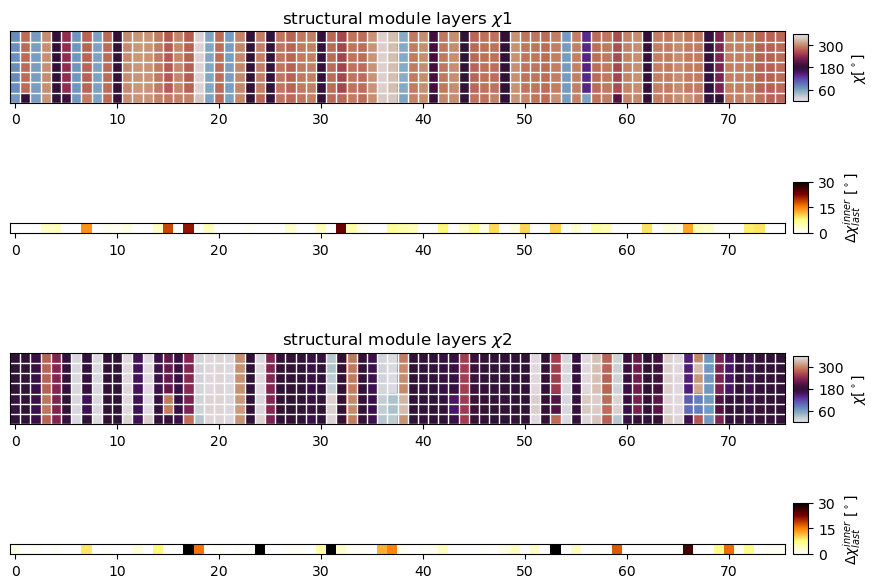

In [11]:
##### FigS2 plot

fig,axs = plt.subplots(4,1, figsize=(10,8))

axs.flatten()

im=axs[0].imshow(np.rad2deg(angles_vs_chitype[1]),cmap='twilight',vmin=0,vmax=360)
cbar_ax = axs[0].inset_axes([1.01, 0.03 , 0.02, 0.93])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax,ticks=[60,180,300],label=r'$\chi$[$^\circ$]')
cbar.ax.tick_params(labelsize=10)
axs[0].set_title(r'structural module layers $\chi$1 ')


im=axs[1].imshow((np.rad2deg(angles_vs_chitype[1][-1,:])-np.rad2deg(circmean(angles_vs_chitype[1][0:-2,:],low=0,high=2*np.pi,axis=0))).reshape(1,-1),cmap='afmhot_r',vmin=0,vmax=30)
cbar_ax = axs[1].inset_axes([1.01, 0.03 , 0.02, 5.])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax,ticks=[0,15,30],label=r'$\Delta \chi^{inner}_{last}$ [$^\circ$]')
cbar.ax.tick_params(labelsize=10)

im=axs[2].imshow(np.rad2deg(angles_vs_chitype[2]),cmap='twilight',vmin=0,vmax=360)
cbar_ax = axs[2].inset_axes([1.01, 0.03 , 0.02, 0.93])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax,ticks=[60,180,300],label=r'$\chi$[$^\circ$]')
cbar.ax.tick_params(labelsize=10)
axs[2].set_title(r'structural module layers $\chi$2 ')

im=axs[3].imshow((np.rad2deg(angles_vs_chitype[2][-1,:])-np.rad2deg(circmean(angles_vs_chitype[2][0:-2,:],low=0,high=2*np.pi,axis=0))).reshape(1,-1),cmap='afmhot_r',vmin=0,vmax=30)
cbar_ax = axs[3].inset_axes([1.01, 0.03 , 0.02, 5.])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax,ticks=[0,15,30],label=r'$\Delta \chi^{inner}_{last}$ [$^\circ$]')
cbar.ax.tick_params(labelsize=10)

for ax in axs:
    ax.set_yticks([])

for ax in [axs[0],axs[2]]:
    for i in range(1,8):  # Horizontal lines
        ax.hlines(i - 0.5, xmin=-0.5, xmax= angles_vs_chitype[1].shape[1]- 0.5, color="white", linewidth=1)
    for j in range(1, angles_vs_chitype[1].shape[1]):  # Vertical lines
        ax.vlines(j - 0.5, ymin=-0.5, ymax=angles_vs_chitype[1].shape[0] - 0.5, color="white", linewidth=1)

plt.savefig('../figures/ubq_layers_struct_module.pdf')

#### load angles

In [12]:
angles_vs_chitype={}
angles_std_vs_chitype={}
angles_lastlayer_vs_chitype={}

chis_target = np.load(glob.glob(f'../data/extra_data/ubq_angles_full_for_fig1.npy')[0])

for chi_type in range(1,5):
        angles=[]
        angles_std=[]
        angles_lastlayer=[]
        for k in range(chis_target.shape[1]):
            angles.append(circmean(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_std.append(circstd(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_lastlayer.append(np.arctan2(chis_target[-1,k,chi_type+2,0],chis_target[-1,k,chi_type+2,1]).astype(np.float64))

        angles = np.array(angles)
        angles_std = np.array(angles_std)
        angles_lastlayer = np.array(angles_lastlayer)

        angles_vs_chitype[chi_type] = angles
        angles_std_vs_chitype[chi_type] = angles_std
        angles_lastlayer_vs_chitype[chi_type] = angles_lastlayer

#### load angles full MSA

In [13]:
angles_vs_chitype_fullMSA={}
angles_std_vs_chitype_fullMSA={}

chis_target = np.load(glob.glob(f'../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output_af2chi_fullmsa/ubq_rank_001_sc_angles.npy')[0])

for chi_type in range(1,5):
        angles=[]
        angles_std=[]
        angles_lastlayer=[]
        for k in range(chis_target.shape[1]):
            angles.append(circmean(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_std.append(circstd(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_lastlayer.append(np.arctan2(chis_target[-1,k,chi_type+2,0],chis_target[-1,k,chi_type+2,1]).astype(np.float64))

        angles = np.array(angles)
        angles_std = np.array(angles_std)
        angles_lastlayer = np.array(angles_lastlayer)

        angles_vs_chitype_fullMSA[chi_type] = angles
        angles_std_vs_chitype_fullMSA[chi_type] = angles_std

#### load angles reduced MSAs

In [14]:
angles_vs_chitype_32MSA={}
angles_std_vs_chitype_32MSA={}

chis_target = np.load(glob.glob(f'../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output_af2chi_32msa//ubq_rank_001_sc_angles.npy')[0])

for chi_type in range(1,5):
        angles=[]
        angles_std=[]
        angles_lastlayer=[]
        for k in range(chis_target.shape[1]):
            angles.append(circmean(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_std.append(circstd(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_lastlayer.append(np.arctan2(chis_target[-1,k,chi_type+2,0],chis_target[-1,k,chi_type+2,1]).astype(np.float64))

        angles = np.array(angles)
        angles_std = np.array(angles_std)
        angles_lastlayer = np.array(angles_lastlayer)

        angles_vs_chitype_32MSA[chi_type] = angles
        angles_std_vs_chitype_32MSA[chi_type] = angles_std

In [15]:
angles_vs_chitype_8MSA={}
angles_std_vs_chitype_8MSA={}

chis_target = np.load(glob.glob(f'../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output_af2chi_8msa/ubq_rank_001_sc_angles.npy')[0])

for chi_type in range(1,5):
        angles=[]
        angles_std=[]
        angles_lastlayer=[]
        for k in range(chis_target.shape[1]):
            angles.append(circmean(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_std.append(circstd(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_lastlayer.append(np.arctan2(chis_target[-1,k,chi_type+2,0],chis_target[-1,k,chi_type+2,1]).astype(np.float64))

        angles = np.array(angles)
        angles_std = np.array(angles_std)
        angles_lastlayer = np.array(angles_lastlayer)

        angles_vs_chitype_8MSA[chi_type] = angles
        angles_std_vs_chitype_8MSA[chi_type] = angles_std

### load pdb

In [53]:
pdb_ensemble_angles_allchi = load_json('../data/struct_data/ubq__pdbs_chis_seqid99.json')

### load 1xqq chis

In [54]:
with open('../data/struct_data/1xqq_allchis.json','r') as f:
    chis_1xqq=json.load(f)

In [55]:
bins_lim=[10*i for i in range(35)]

In [56]:
bins_mean=[i for i in range(5,360,10)]

In [57]:
circmean_1xqq={}
circmean_1xqq['chi1']={}
circmean_1xqq['chi2']={}
for sel_chi in ['chi1','chi2']:
    for key in chis_1xqq[sel_chi].keys():
        circmean_1xqq[sel_chi][key]=circmean(np.array(chis_1xqq['chi1'][key]).reshape(-1,1),axis=0,low=0,high=2*np.pi)

In [58]:
dist_chis_1xqq={}
dist_chis_1xqq['chi1']={}
dist_chis_1xqq['chi2']={}
for sel_chi in ['chi1','chi2']:
    for key in chis_1xqq[sel_chi].keys():
        std_chi=circmean(np.array(chis_1xqq['chi1'][key]).reshape(-1,1),axis=1,low=0,high=2*np.pi)
        dist_chis_1xqq[sel_chi][key]=np.histogram(np.rad2deg(std_chi),range=(0,360),bins=36)[0]

In [59]:
is_1xqq_fixed={}
is_1xqq_fixed['chi1']={}
is_1xqq_fixed['chi2']={}
for sel_chi in ['chi1','chi2']:
    for idx,res in enumerate(dist_chis_1xqq[sel_chi].keys()):
            red_pop=rot_pop_rebinned_to_three(dist_chis_1xqq[sel_chi][res])
            if np.count_nonzero(red_pop)>1:
                is_1xqq_fixed[sel_chi][res]=False
            else:
                is_1xqq_fixed[sel_chi][res]=True

### circulat plot chi1 comparison

In [23]:
sel_chi='chi1'
angles_chi1_in_1xqq=[]
last_chi1_in_1xqq=[]

angles_chi1_1xqq=[]
dict_idx={}
for idx,res in enumerate(circmean_1xqq[sel_chi].keys()):
    angles_chi1_in_1xqq.append(angles_vs_chitype[int(sel_chi[3:])][int(res[3:])-1])
    last_chi1_in_1xqq.append(angles_lastlayer_vs_chitype[int(sel_chi[3:])][int(res[3:])-1])
    angles_chi1_1xqq.append(circmean_1xqq[sel_chi][res])
    dict_idx[idx]=res

In [24]:
# Define a colormap with a consistent color order
cmap = plt.cm.get_cmap('rainbow', len(angles_chi1_1xqq))

# Use the index as color for each point
colours = [cmap(i) for i in range(len(angles_chi1_1xqq))]

/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_94907/3610764793.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(angles_chi1_1xqq))


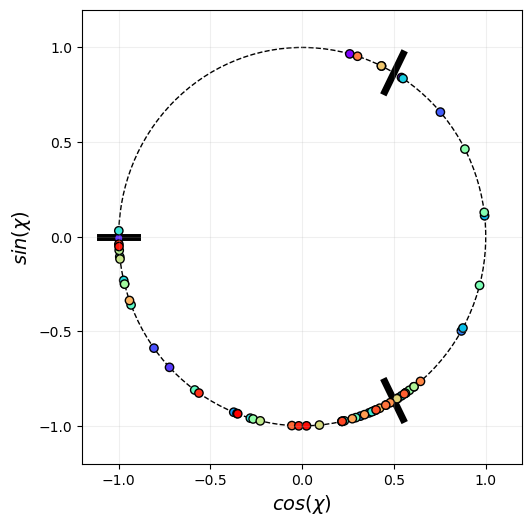

In [28]:
###### Fig1 - 1xqq mean chi1s
plot_circcorrl(np.array(angles_chi1_1xqq),is_fixed=np.array([True for i in range(len(angles_chi1_1xqq))]), plot_title=f'1XQQ $\chi_{sel_chi[3:]}$',color=colours,savepath=f'../figures/ensemble_1xqq_chi1_all.pdf')


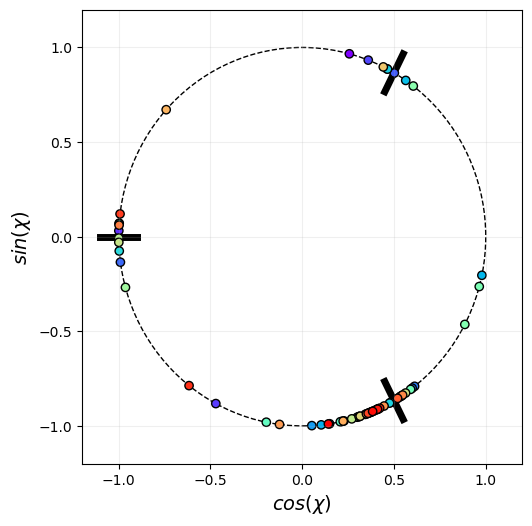

In [29]:
###### Fig1 - af2chi internal chi1s

plot_circcorrl(np.array(angles_chi1_in_1xqq),is_fixed=np.array([True for i in range(len(angles_chi1_1xqq))]), plot_title=f'internal $\chi_{sel_chi[3:]}$',color=colours,savepath=f'../figures/AF2internal_1xqq_chi1_all.pdf')


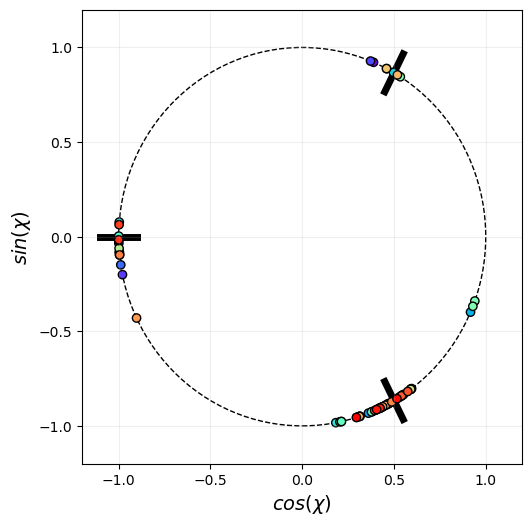

In [30]:
###### Fig1 - af2chi last chi1s

plot_circcorrl(np.array(last_chi1_in_1xqq),is_fixed=np.array([True for i in range(len(angles_chi1_1xqq))]), plot_title=f'last $\chi_{sel_chi[3:]}$',color=colours,savepath=f'../figures/AF2last_1xqq_chi1_all.pdf')

### scatterplot correlation

#### chi1

ax1 circcorr: 0.8789394
ax1 rmse: 1.7497800290397942
ax2 circcorr: 0.8104805
ax2 rmse: 1.7728260373989067
ax3 circcorr: 0.7995241
ax3 rmse: 1.8936549475417794


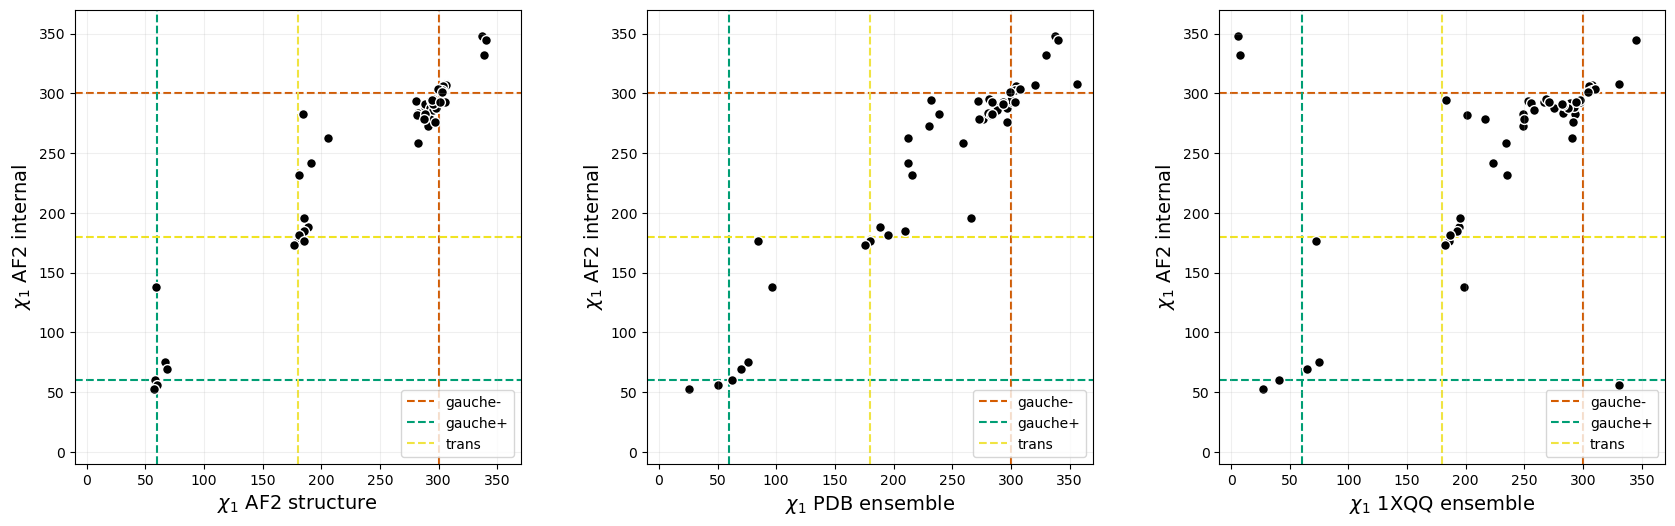

In [60]:
#### Fig 1j - S3  internal - decoy template - multi wells only 


plot_circcorr_only(angles_vs_chitype[1],
              angles_lastlayer_vs_chitype[1],
              angles_std_vs_chitype[1],
              pdb_ensemble_angles_allchi,
              chis_1xqq,
              'chi1',
              pdb_ensemble_angles_allchi['chi1'].keys(),
              which_layer='internal',
              is_fixed=is_1xqq_fixed,
              savepath='../figures/ubq_motivation_plots_chi1_inner_layer_multi.pdf')

ax1 circcorr: 0.8793089
ax1 rmse: 1.7892705981807795
ax2 circcorr: 0.8105511
ax2 rmse: 1.7213461448618552
ax3 circcorr: 0.7994684
ax3 rmse: 1.8614820698079264


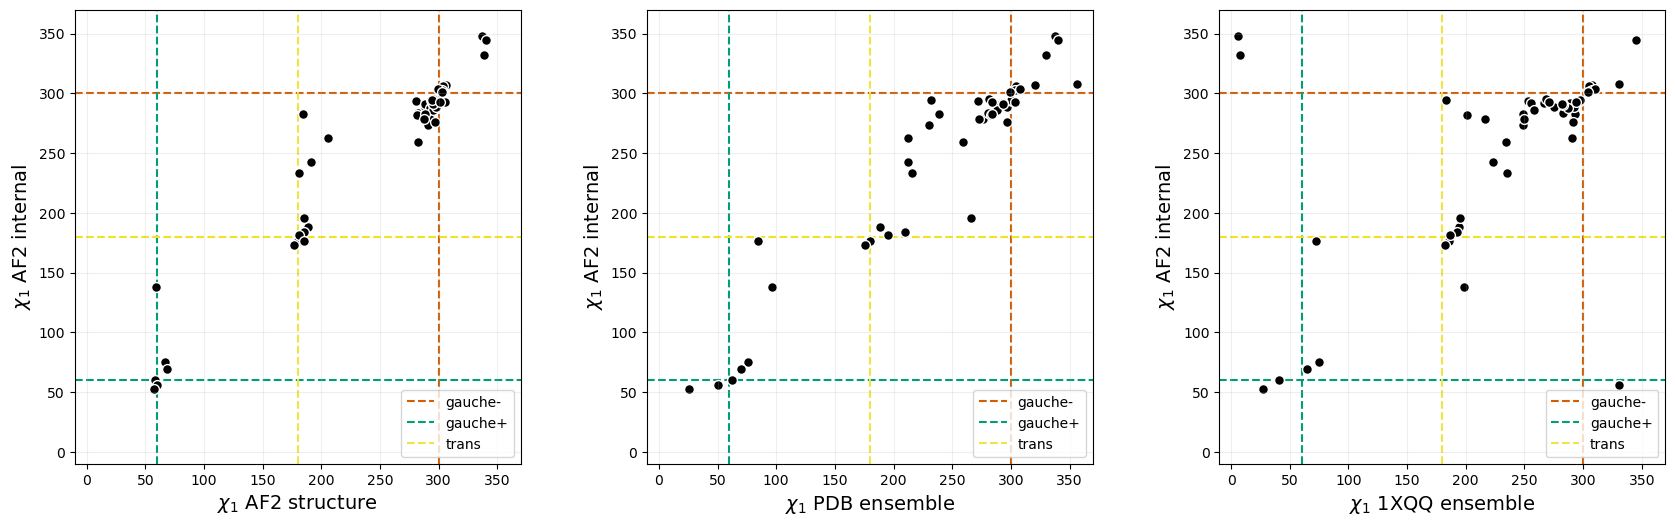

In [61]:
## Fig S3 - full msa no template  - multi wells only 

plot_circcorr_only(angles_vs_chitype_fullMSA[1],
              angles_lastlayer_vs_chitype[1],
              angles_std_vs_chitype_fullMSA[1],
              pdb_ensemble_angles_allchi,
              chis_1xqq,
              'chi1',
              pdb_ensemble_angles_allchi['chi1'].keys(),
                   which_layer='internal',
              is_fixed=is_1xqq_fixed,
                  savepath='../figures/ubq_motivation_plots_chi1_inner_layer_fullMSA.pdf')

ax1 circcorr: 0.943534
ax1 rmse: 1.8461344202999725
ax2 circcorr: 0.8500737
ax2 rmse: 1.763468848463481
ax3 circcorr: 0.7284074
ax3 rmse: 1.97314541652877


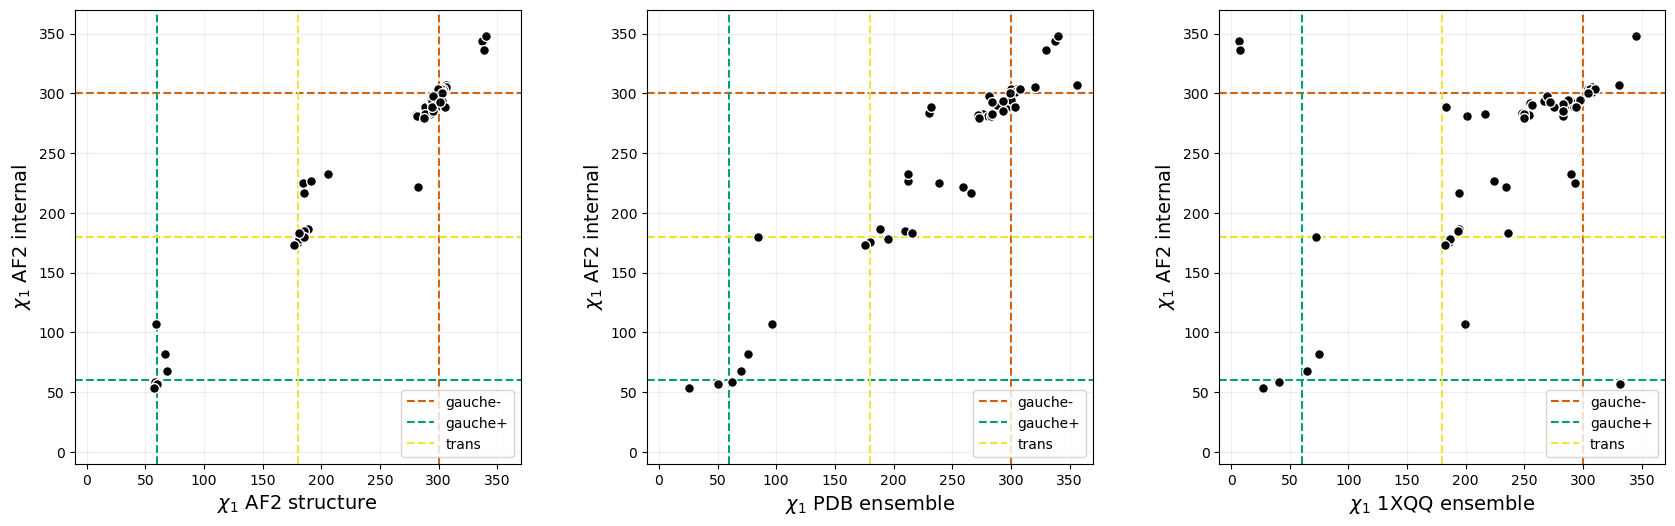

In [44]:
## Fig S3 - 32 msa no template  - multi wells only 


plot_circcorr_only(angles_vs_chitype_32MSA[1],
              angles_lastlayer_vs_chitype[1],
              angles_std_vs_chitype_32MSA[1],
              pdb_ensemble_angles_allchi,
              chis_1xqq,
              'chi1',
              pdb_ensemble_angles_allchi['chi1'].keys(),
                   which_layer='internal',
              is_fixed=is_1xqq_fixed,
                  savepath='../figures/ubq_motivation_plots_chi1_inner_layer_32MSA.pdf')

ax1 circcorr: 0.920379
ax1 rmse: 1.9807141079343353
ax2 circcorr: 0.8947393
ax2 rmse: 1.947401050836567
ax3 circcorr: 0.7033287
ax3 rmse: 1.698497527792231


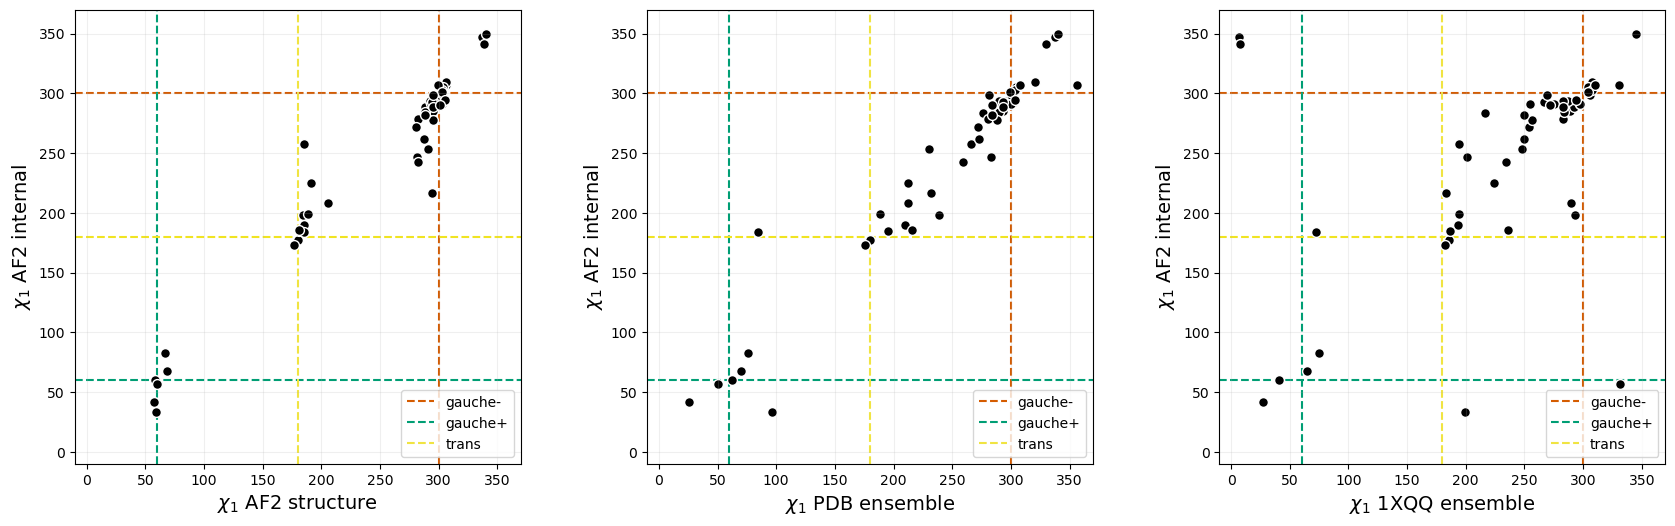

In [45]:
## Fig S3 - 8 msa no template  - multi wells only 

plot_circcorr_only(angles_vs_chitype_8MSA[1],
              angles_lastlayer_vs_chitype[1],
              angles_std_vs_chitype_32MSA[1],
              pdb_ensemble_angles_allchi,
              chis_1xqq,
              'chi1',
              pdb_ensemble_angles_allchi['chi1'].keys(),
                   which_layer='internal',
              is_fixed=is_1xqq_fixed,
                  savepath='../figures/ubq_motivation_plots_chi1_inner_layer_8MSA.pdf')

ax1 circcorr: 1.0
ax1 rmse: 0.0
ax2 circcorr: 0.839726
ax2 rmse: 1.67638543090111
ax3 circcorr: 0.6269317
ax3 rmse: 1.6503840155514757


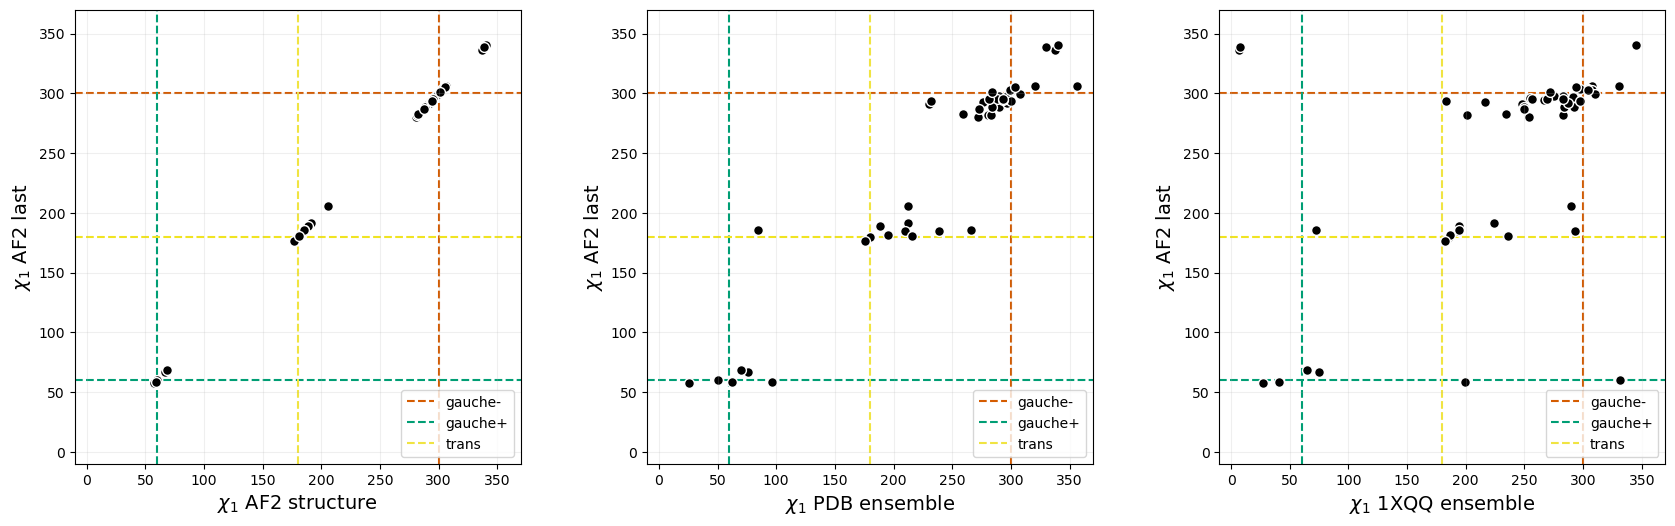

In [46]:
## Fig 1i  - multi wells only 


plot_circcorr_only(angles_lastlayer_vs_chitype[1],
              angles_lastlayer_vs_chitype[1],
              angles_std_vs_chitype[1],
              pdb_ensemble_angles_allchi,
              chis_1xqq,
              'chi1',
              pdb_ensemble_angles_allchi['chi1'].keys(),
                   which_layer='last',
                   is_fixed=is_1xqq_fixed,
                  savepath='../figures/ubq_motivation_plots_chi1_last_layer_multi.pdf')

#### chi2

ax1 circcorr: 0.9082351
ax1 rmse: 1.8041137429649416
ax2 circcorr: 0.7005065
ax2 rmse: 1.8897337585153995
ax3 circcorr: 0.5541477
ax3 rmse: 1.6717540712772063


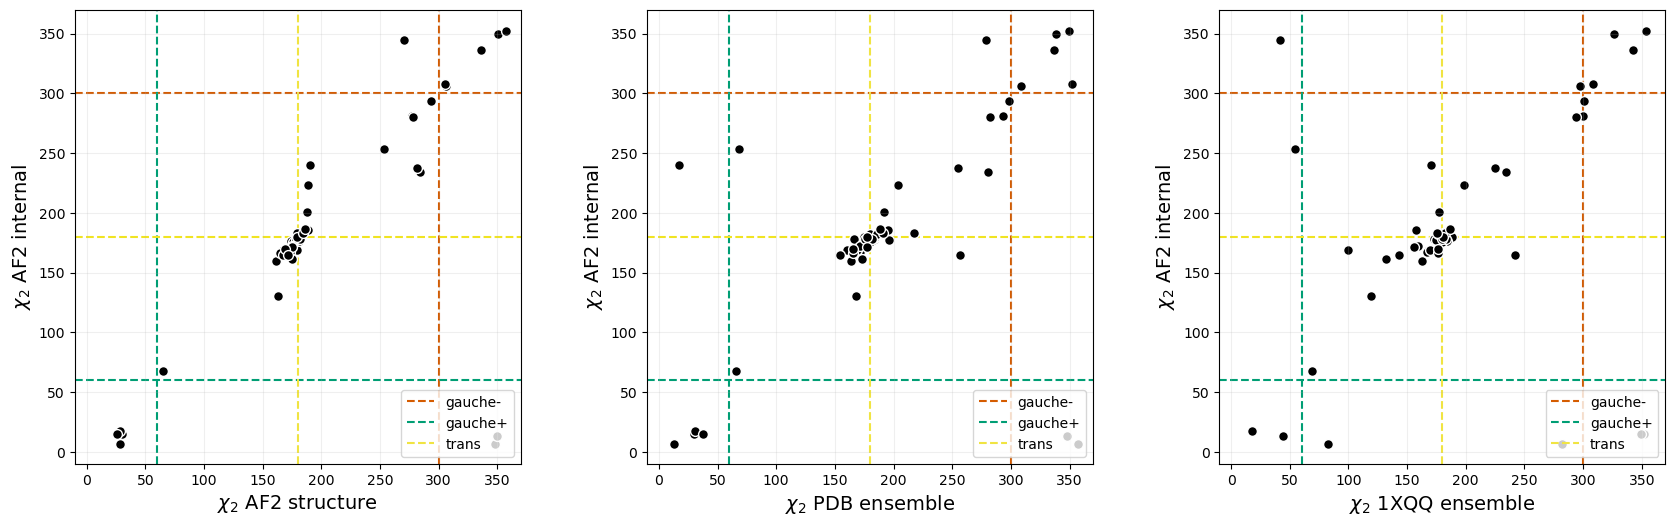

In [47]:
## Fig S2 - chi2 single - decoy template

plot_circcorr_only(angles_vs_chitype[2],
              angles_lastlayer_vs_chitype[2],
              angles_std_vs_chitype[2],
              pdb_ensemble_angles_allchi,
              chis_1xqq,
              'chi2',
              pdb_ensemble_angles_allchi['chi2'].keys(),
                  savepath='../figures/ubq_motivation_plots_chi2_internal_layers.pdf')

ax1 circcorr: 1.0
ax1 rmse: 0.0
ax2 circcorr: 0.771692
ax2 rmse: 1.9352210605345683
ax3 circcorr: 0.5144716
ax3 rmse: 2.028480222908416


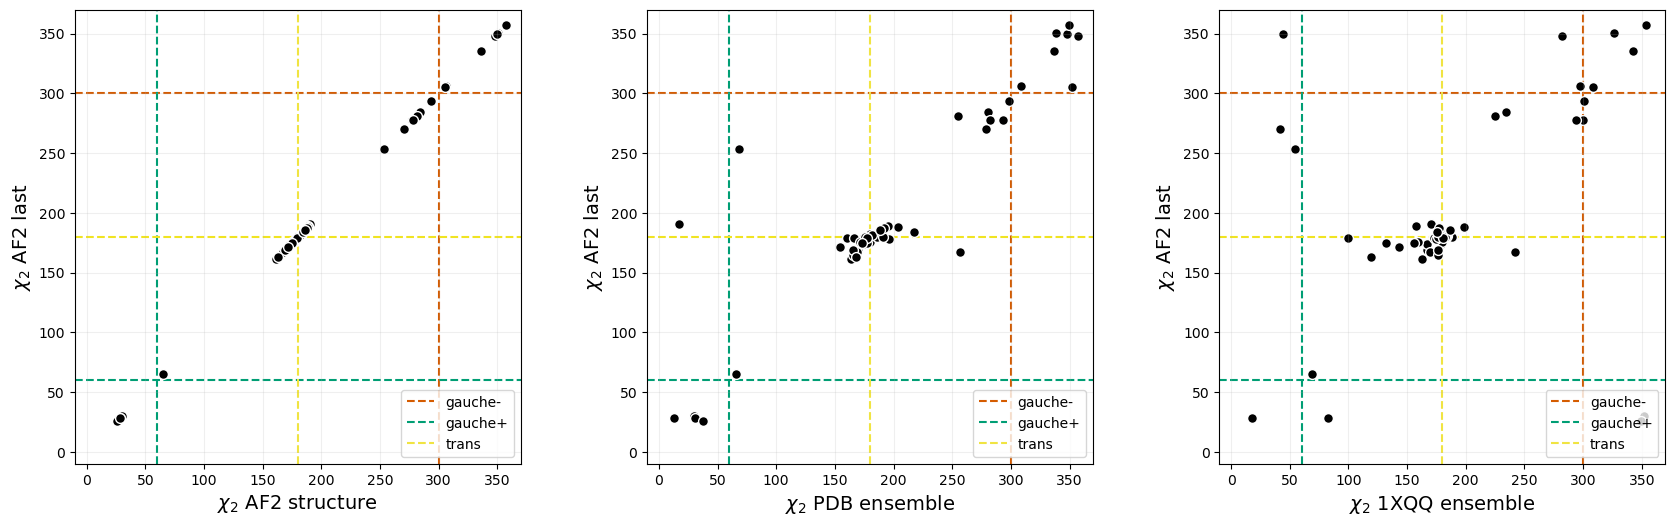

In [48]:
## Fig S2 chi2 AF2 structure

plot_circcorr_only(angles_lastlayer_vs_chitype[2],
              angles_lastlayer_vs_chitype[2],
              angles_std_vs_chitype[2],
              pdb_ensemble_angles_allchi,
              chis_1xqq,
              'chi2',
              pdb_ensemble_angles_allchi['chi2'].keys(),
                which_layer='last',
                   savepath='../figures/ubq_motivation_plots_chi2_last_layer.pdf')

## scan prior

In [50]:
prior_scan_distributions = []
reweighted_scan_distributions = []

for struct_weight in np.arange(0.00, 1.01, 0.05):
    pops_fitted = load_json(f'../data/af2chi_data/prior_scan_ubq/output_{struct_weight:.2f}/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_pops_fitted.json')
    pops_prior = load_json(f'../data/af2chi_data/prior_scan_ubq/output_{struct_weight:.2f}/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_pops_priori.json')

    reweighted_scan_distributions.append(pops_fitted)
    prior_scan_distributions.append(pops_prior)

In [51]:
pdb_ensemble_angles_allchi = load_json('../data/struct_data/UBQ_seqid95_all_chis_pdbensemble.json')

37 36
37 36


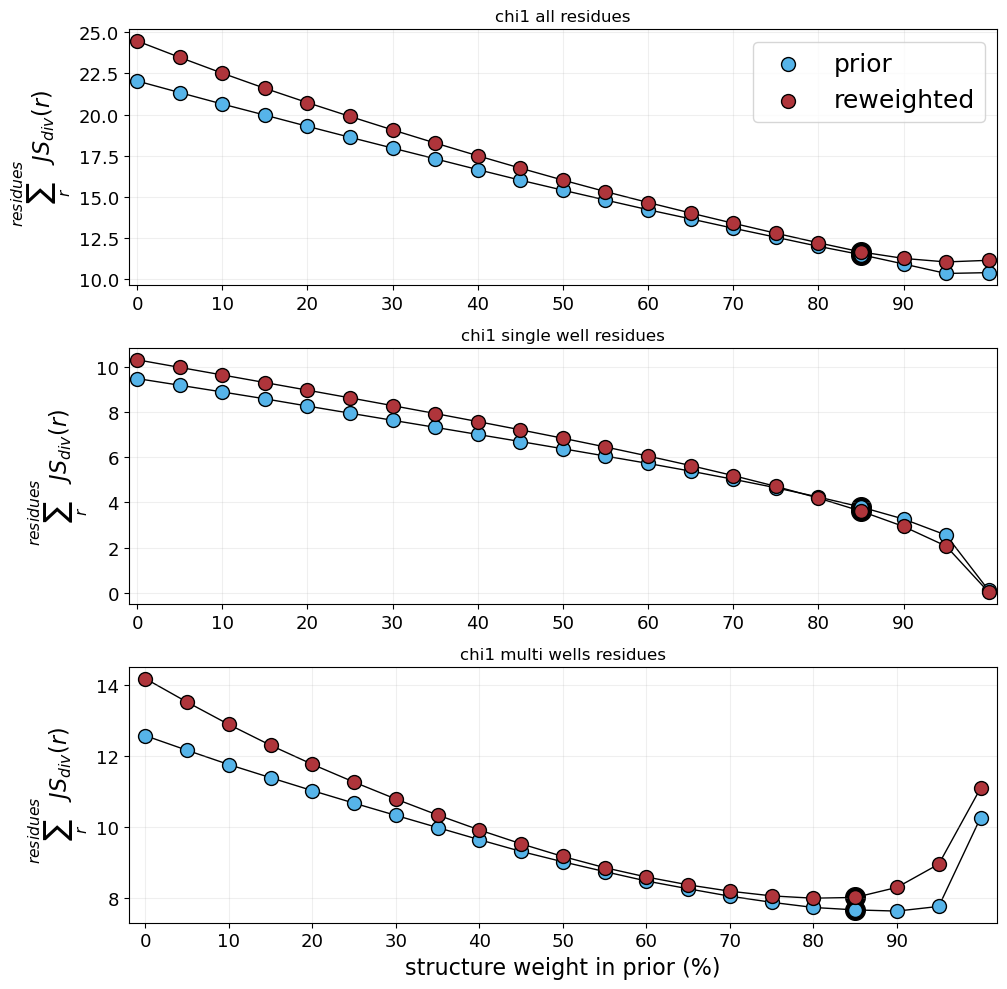

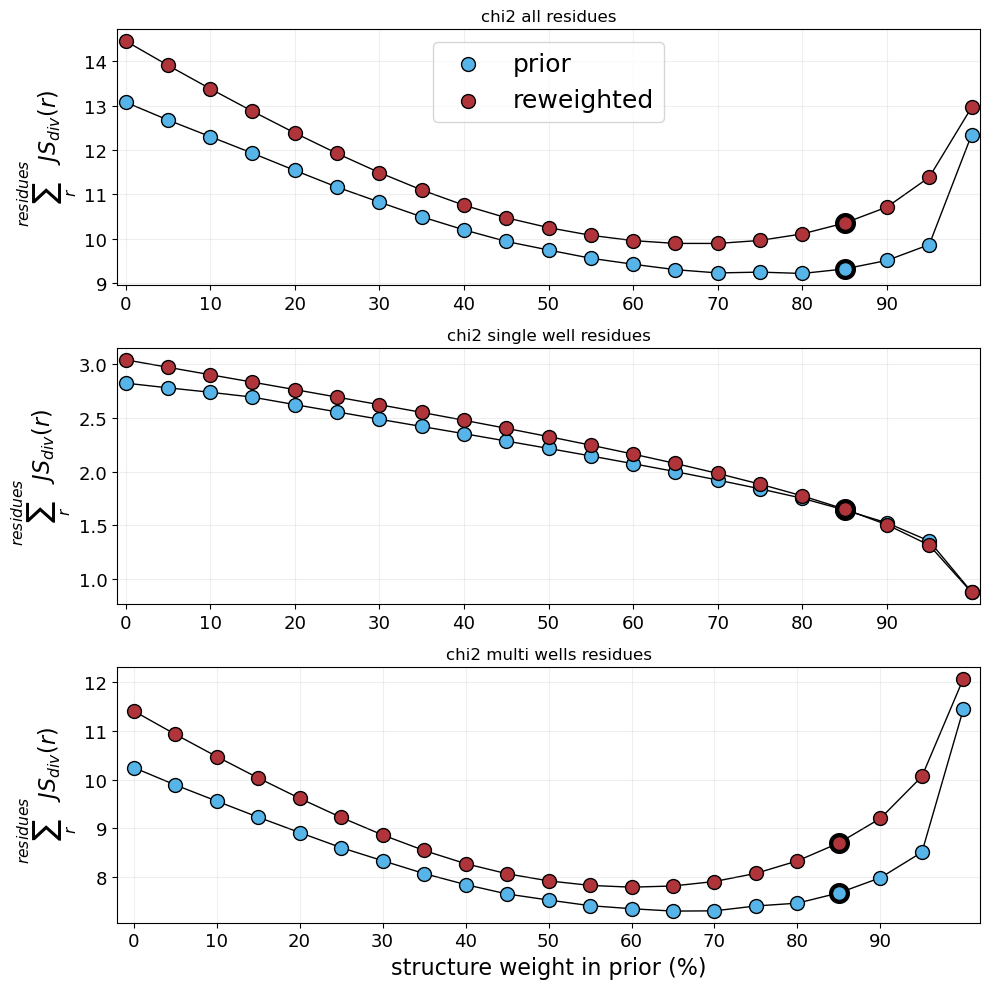

In [52]:
##### Fig S4a - prior scan weight struct 
for chi_idx in range(2):
    chi_type = f'chi{chi_idx+1}'
    pdb_ensemble_angles=pdb_ensemble_angles_allchi[chi_type]
    pdb_ensemble_angles_distr={}

    x=[i for i in range(5,360,10)]
    x_range=[i for i in range(0,365,10)]
    print(len(x_range),len(x))
    for key in pdb_ensemble_angles.keys():
        
        pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
        
        pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)
    js_scan_sum_re=[]
    js_scan_sum_prior=[]
    for perc in range(len(prior_scan_distributions)):
        js_re=[]
        js_prior=[]
        for idx,res in enumerate(reweighted_scan_distributions[perc][chi_type].keys()):
            if res in pdb_ensemble_angles_distr.keys():
                js_re.append(jensenshannon(rot_pop_rebinned_to_three(reweighted_scan_distributions[perc][chi_type][res]),rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])))
                js_prior.append(jensenshannon(rot_pop_rebinned_to_three(prior_scan_distributions[perc][chi_type][res]),rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])))

        js_scan_sum_re.append(np.sum(js_re))
        js_scan_sum_prior.append(np.sum(js_prior))
    is_fixed={}

    for idx,res in enumerate(prior_scan_distributions[0][chi_type].keys()):
        if res in pdb_ensemble_angles_distr.keys():
            red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
            if np.count_nonzero(red_pop)>1:
                is_fixed[res]=False
            else:
                is_fixed[res]=True

                                            
    js_scan_sum_re_fixed=[]
    js_scan_sum_prior_fixed=[]

    js_scan_sum_re_multi=[]
    js_scan_sum_prior_multi=[]

    for perc in range(len(prior_scan_distributions)):
        js_re_multi=[]
        js_prior_multi=[]

        js_re_fixed=[]
        js_prior_fixed=[]
        
        for idx,res in enumerate(reweighted_scan_distributions[perc][chi_type].keys()):

            if res in pdb_ensemble_angles_distr.keys():
                if is_fixed[res]:
                    js_re_fixed.append(jensenshannon(rot_pop_rebinned_to_three(reweighted_scan_distributions[perc][chi_type][res]),rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])))
                    js_prior_fixed.append(jensenshannon(rot_pop_rebinned_to_three(prior_scan_distributions[perc][chi_type][res]),rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])))
                else:
                    js_re_multi.append(jensenshannon(rot_pop_rebinned_to_three(reweighted_scan_distributions[perc][chi_type][res]),rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])))
                    js_prior_multi.append(jensenshannon(rot_pop_rebinned_to_three(prior_scan_distributions[perc][chi_type][res]),rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])))
        
        js_scan_sum_re_fixed.append(np.sum(js_re_fixed))
        js_scan_sum_prior_fixed.append(np.sum(js_prior_fixed))

        js_scan_sum_re_multi.append(np.sum(js_re_multi))
        js_scan_sum_prior_multi.append(np.sum(js_prior_multi))

    fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(10,10))

    ax1.scatter([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_re,s=100,edgecolor='k',facecolor='#56b4e9',label='prior')
    ax1.scatter([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_prior,s=100,edgecolor='k',facecolor='#AF353B',label='reweighted')
    ax1.scatter(85,js_scan_sum_re[17],color='k',s=200,zorder=-50)
    ax1.scatter(85,js_scan_sum_prior[17],color='k',s=200,zorder=-50)

    ax1.plot([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_re,lw=1,c='k',zorder=-100)
    ax1.plot([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_prior,lw=1,c='k',zorder=-100)

    ax1.tick_params(labelsize=13)
    ax1.set_xlim(-1,101)
    ax1.set_title(f'{chi_type} all residues')
    ax1.set_ylabel(r'$\sum_{r}^{residues} JS_{div}(r)$',fontsize=16)
    ax1.grid(alpha=0.2,zorder=-200)
    ax1.set_axisbelow(True)
    ax1.set_xticks(np.arange(0,100,10))
    ax1.legend(fontsize=18)
    
    ax2.scatter([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_re_fixed,s=100,edgecolor='k',facecolor='#56b4e9')
    ax2.scatter([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_prior_fixed,s=100,edgecolor='k',facecolor='#AF353B')
    ax2.plot([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_re_fixed,lw=1,c='k',zorder=-100)
    ax2.plot([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_prior_fixed,lw=1,c='k',zorder=-100)
    ax2.scatter(85,js_scan_sum_re_fixed[17],color='k',s=200,zorder=-50)
    ax2.scatter(85,js_scan_sum_prior_fixed[17],color='k',s=200,zorder=-50)

    ax2.tick_params(labelsize=13)
    ax2.set_xlim(-1,101)
    ax2.set_title(f'{chi_type} single well residues')
    ax2.set_ylabel(r'$\sum_{r}^{residues} JS_{div}(r)$',fontsize=16)
    ax2.grid(alpha=0.2,zorder=-200)
    ax2.set_axisbelow(True)
    ax2.set_xticks(np.arange(0,100,10))

    ax3.scatter([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_re_multi,s=100,edgecolor='k',facecolor='#56b4e9')
    ax3.scatter([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_prior_multi,s=100,edgecolor='k',facecolor='#AF353B')
    ax3.plot([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_re_multi,lw=1,c='k',zorder=-100)
    ax3.plot([5*i for i in range(len(prior_scan_distributions))],js_scan_sum_prior_multi,lw=1,c='k',zorder=-100)
    ax3.scatter(85,js_scan_sum_re_multi[17],color='k',s=200,zorder=-50)
    ax3.scatter(85,js_scan_sum_prior_multi[17],color='k',s=200,zorder=-50)

    ax3.tick_params(labelsize=13)
    ax3.set_xlim(-2,102)
    ax3.set_title(f'{chi_type} multi wells residues')
    ax3.set_ylabel(r'$\sum_{r}^{residues} JS_{div}(r)$',fontsize=16)
    ax3.set_xlabel ('structure weight in prior (%)',fontsize=16)
    ax3.grid(alpha=0.2,zorder=-200)
    ax3.set_axisbelow(True)
    ax3.set_xticks(np.arange(0,100,10))

    fig.tight_layout()
    plt.savefig(f'../figures/ubq_scanratio_pdbensemble_JS_{chi_type}.pdf')